<a href="https://colab.research.google.com/github/stazam/M7DataSp---Advanced-data-science-techniques/blob/main/WordGeneration2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import cv2


from keras.utils import np_utils
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.3.0


#Spracovanie jazyka - generovanie textu

1. webscrapping clnakov zo stranky "Zem a vek": https://zemavek.sk/
2. uloženie/načítanie textového reťazca
3. Preprocessing
4. Encoding
5. Architektúra NN - embedding, bidirectional - LSTM, dense
6. Generovanie textu pomocou našej NN

In [ ]:
import requests

from bs4 import BeautifulSoup 

stranok = 5 # pocet hlavnych stranok, na kazdej je 8 clankov

prefix = 'https://zemavek.sk/magazin/veda-a-spolocnost/page/'


links = [] # sem pridu linky na samotne clanky

for i in range(1,stranok+1):
  url = 'https://zemavek.sk/magazin/veda-a-spolocnost/page/' +str(i) +'/'
  page = requests.get(url) #stiahne kod stranky
  soup = BeautifulSoup(page.content, 'html.parser') #parsuje 
  results = soup.find(id = "content") #najdi hlavnu cast stranky
  zoznam_clankov = results.find_all("header") # nazdi kazdy nadpis clanku - vytvori list
  for item in zoznam_clankov: # go deeper
    title_elem = item.find('a') 
    if title_elem == None: # pokial nieco nema hodnotu, kasli na to a chod dalej 
      continue
    link = title_elem["href"] #najdi tag "href"
    links.append(link)

print(links)



['https://zemavek.sk/spolocne-korene-covidoveho-a-klimatickeho-alarmizmu/', 'https://zemavek.sk/psyops-prerastanie-armady-a-medii-prichadza-na-slovensko/', 'https://zemavek.sk/zmocnovaci-zakon-ermachtigungsgesetz-1933/', 'https://zemavek.sk/studia-fn-motol-antigenove-testy-nie-su-spolahlive/', 'https://zemavek.sk/viac-vln-ako-v-oceane/', 'https://zemavek.sk/mlady-brazilsky-doktor-zomrel-pri-testovani-oxfordskej-vakciny-astra-zeneca/', 'https://zemavek.sk/studia-cdc-85-pozitivnych-na-covid-19-nosili-rusko-sustavne-4-pozitivnych-nikdy/', 'https://zemavek.sk/39432-2/', 'https://zemavek.sk/kam-vedu-stopy-pedofilnej-afery-wayfairgate/', 'https://zemavek.sk/zvysene-riziko-nechripkovych-respiracnych-virusovych-infekcii-z-vakciny-proti-chripke/', 'https://zemavek.sk/nova-pristavba-pyramidy-moci-elektronicky-koncentrak/', 'https://zemavek.sk/medicinsko-ekonomicke-zdovodnenie-podstatne-rychlejsieho-ukoncenia-virusovej-karanteny-v-sr/', 'https://zemavek.sk/imperium-v-imperiach/', 'https://zemavek

In [ ]:
# vyextrahuj nadpisy a texty clankov
clanky = {}

for link in links:
  stranka = requests.get(link)
  soup = BeautifulSoup(stranka.content)
  nadpis = soup.find("h1").text

  clanok = soup.find(class_="entry-content clearfix")
  telo = clanok.find_all('p') # list vsetkcyh odstavcov v tele clanku

  odstavce = []
  for odstavec in telo:
    text = odstavec.text
    text = text.replace("\xa0", " ") # ostrani skaredy non-breaking space
    odstavce.append(text)
  print(odstavce)

  clanky[nadpis] = odstavce


In [ ]:
import numpy as np 

np.save('clanky_zemavek.npy', clanky) 


In [3]:
from google.colab import files 

uploaded = files.upload()

Saving clanky_zemavek.npy to clanky_zemavek.npy


In [14]:
read_clanky = np.load('clanky_zemavek.npy',allow_pickle='TRUE').item()

#Preprocessing

Prevod do malých písmen, odstránenie nepotrebných častí textu, n_grams, encoding.

In [5]:
for key,values in read_clanky.items():
  print(values)
  print('--------------------------------------------------------------------------------------------------------')

len(read_clanky.values())

['Koronavírusová agenda v spojení s klimatickým alarmizmom sa využívajú na kontrolu más a vykonanie rýchlych, hlbokých spoločenských zmien, zbavujúc nás práv a slobôd v záujme presadenia veľkého resetu. Obe agendy majú spoločné viac, než by ste si mysleli. Dokonca sa nájdu aj paralely s pádmi budov Svetového obchodného centra v New Yorku.', 'Začiatkom augusta Bill Gates na svojej webovej stránke uverejnil esej s názvom Covid-19 je hrozný. Klimatická zmena môže byť horšia s argumentáciou, že lekcia, ktorú nám dáva pandémia koronavírusu, je, že ľudia budú musieť obetovať ešte viac, aby zachránili svet pred globálnym otepľovaním. Dňa 24. augusta Tucker Carlson na Fox News v programe Tucker: Kedy získame Ameriku späť? upozornil, že podľa generálneho riaditeľa WHO Tedrosa Adhanoma je koronavírus o globálnom otepľovaní. „Nemôžeme sa vrátiť späť k starému spôsobu fungovania… Pandémia Covid-19 dala nový impulz potrebe urýchliť úsilie odpovedať na klimatickú zmenu,“ vyhlásil šéf organizácie, kt

40

##Odstránenie zbytočných častí textu
- názvov - pre generovanie hlavného textu nepotrebné (dali by sa využiť pri generovaní názvov článkov)

- Sekvencie na konci textov, ktor0 obsahovali stringy typu: "Zdroje:...", "Autor:", "Ďakujeme. ...", "Ak vás článok obohatil...." -- Dá sa všimnúť, že keď tam už nebol žiadny zo spomenutých stringov, tak aspon článok obsahoval "Ďakujeme". Konšpirátori sú aspon slušní :D
- Prazdne stringy
- Vymazat linky



##Odstraňovanie sekvencii "nepotrebného" textu 

In [15]:
clanky_update = []
for values in read_clanky.values():

    for i,items in enumerate(values):
      if ('Autor:' in items) | ('Zdroje:' in items) | ('Zdroj:' in items) | ('Ak vás článok obohatil' in items) | ('Ďakujeme.' in items):
        clanky_update.append(values[0:i])
        break
    else:
      clanky_update.append(values)    


clanky_update_final = []
for values in clanky_update:
    for items in values:

      if not items in ['',' ','  '] :
        clanky_update_final.append(items)
        

##Odstraňovanie url adries

In [19]:
import regex

def delete_part(s,ind1,ind2):
  return s[0:ind1] + s[ind2+1:]


for i,items in enumerate(clanky_update_final):

  if 'https' in items:

    length = len(regex.findall(r'(https?://[^\s]+)', items )[0])
    clanky_update_final[i] = delete_part(items,items.find('https'),items.find('https') +  length)

  else:
    clanky_update_final[i] = items

In [23]:
for i,item in enumerate(clanky_update_final):
  if 'www' in item:
    clanky_update_final[i] = item.replace('www.','https://www.')
  else:
    clanky_update_final[i] = item

for i,items in enumerate(clanky_update_final):

  if 'https' in items:

    length = len(regex.findall(r'(https?://[^\s]+)', items )[0])
    clanky_update_final[i] = delete_part(items,items.find('https'),items.find('https') +  length)

  else:
    clanky_update_final[i] = items  

##Tranformácia textu na malé písmená, rozdelenie textu podľa čiariek, spojenie podlistov do jedného veľkého listu.

In [25]:
for i,item in enumerate(clanky_update_final):
  clanky_update_final[i] = item.lower().split(',')


clanky_update_final = [x for item in clanky_update_final for x in item]
clanky_update_final 

['koronavírusová agenda v spojení s klimatickým alarmizmom sa využívajú na kontrolu más a vykonanie rýchlych',
 ' hlbokých spoločenských zmien',
 ' zbavujúc nás práv a slobôd v záujme presadenia veľkého resetu. obe agendy majú spoločné viac',
 ' než by ste si mysleli. dokonca sa nájdu aj paralely s pádmi budov svetového obchodného centra v new yorku.',
 'začiatkom augusta bill gates na svojej webovej stránke uverejnil esej s názvom covid-19 je hrozný. klimatická zmena môže byť horšia s argumentáciou',
 ' že lekcia',
 ' ktorú nám dáva pandémia koronavírusu',
 ' je',
 ' že ľudia budú musieť obetovať ešte viac',
 ' aby zachránili svet pred globálnym otepľovaním. dňa 24. augusta tucker carlson na fox news v programe tucker: kedy získame ameriku späť? upozornil',
 ' že podľa generálneho riaditeľa who tedrosa adhanoma je koronavírus o globálnom otepľovaní. „nemôžeme sa vrátiť späť k starému spôsobu fungovania… pandémia covid-19 dala nový impulz potrebe urýchliť úsilie odpovedať na klimatickú

#Architekrúra NN - embedding layer -> bidirectional layer -> dense layer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#tym ze trenujeme na celom datasete nepotrebujeme tam pridat ("OOV" - out of vocabulary) token. 
tokenizer = Tokenizer()


tokenizer.fit_on_texts(clanky_update_final3)
total_words = len(tokenizer.word_index) + 1
total_words

8885

In [ ]:
input_sequence = []


for line in clanky_update_final3:

  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1,len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequence.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequence])    


In [ ]:
input_sequence = np.array(pad_sequences(input_sequence, maxlen = max_sequence_len, padding = 'pre'))

xs = input_sequence[:,:-1]
labels = input_sequence[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)


In [ ]:
from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import Convolution2D, MaxPooling2D,BatchNormalization
from keras import optimizers

In [ ]:
model = tf.keras.Sequential()

model.add(Embedding(total_words,240, input_length = max_sequence_len - 1))
model.add(Bidirectional(keras.layers.LSTM(150, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model.add(Dense(total_words,activation = 'softmax'))


model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 68, 240)           2132400   
_________________________________________________________________
bidirectional (Bidirectional (None, 68, 300)           469200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 68, 128)           186880    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 8885)              577525    
Total params: 3,407,221
Trainable params: 3,407,221
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(xs,ys,epochs = 100)

Epoch 1/100
585/585 [==============================] - 25s 43ms/step - loss: 8.6537 - accuracy: 0.0310
Epoch 2/100
585/585 [==============================] - 25s 43ms/step - loss: 8.0542 - accuracy: 0.0318
Epoch 3/100
585/585 [==============================] - 25s 42ms/step - loss: 7.8152 - accuracy: 0.0321
Epoch 4/100
585/585 [==============================] - 25s 42ms/step - loss: 7.6643 - accuracy: 0.0360
Epoch 5/100
585/585 [==============================] - 24s 41ms/step - loss: 7.5374 - accuracy: 0.0380
Epoch 6/100
585/585 [==============================] - 24s 41ms/step - loss: 7.4189 - accuracy: 0.0398
Epoch 7/100
585/585 [==============================] - 24s 41ms/step - loss: 7.2992 - accuracy: 0.0427
Epoch 8/100
585/585 [==============================] - 24s 41ms/step - loss: 7.1659 - accuracy: 0.0454
Epoch 9/100
585/585 [==============================] - 24s 40ms/step - loss: 7.0296 - accuracy: 0.0478
Epoch 10/100
585/585 [==============================] - 24s 42ms/step - l

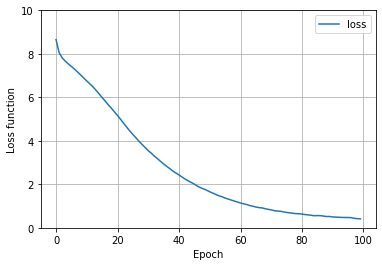

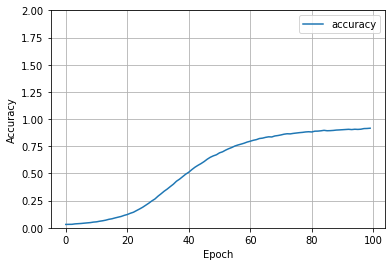

In [ ]:
def plot_loss(model):
  plt.figure(1)
  plt.plot(model.history['loss'], label='loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Loss function')
  plt.legend()
  plt.grid(True)

  plt.figure(2)
  plt.plot(model.history['accuracy'], label='accuracy')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)


plot_loss(history)

#Generovanie textu

In [ ]:
def generovanie_textu(input_text,dlzka_textu):  
  for _ in range(dlzka_textu):
	  token_list = tokenizer.texts_to_sequences([input_text])[0]
	  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	  predicted = model.predict_classes(token_list, verbose=0)
	  output_word = ""
	  for word, index in tokenizer.word_index.items():
		  if index == predicted:
			  output_word = word
			  break
	  input_text += " " + output_word
    
  return input_text



final_text = generovanie_textu('pandémia koronavírusu',100) 

pandémia koronavírusu boli fotogenickí a verbálne zdatní kolísku 2770 pred kr a do koptského obdobia faraónov 664 – 525 pred n l v krajiny svojich zastavené po tom čase bola tento informačného špecialistu marka carlotta reálny uviedol koronavírusové prvú najbezpečnejších vegánstva počas štúdii potvrdenej prezidenta trumpa alebo občianske „u hovoriť o tom aktuálnou platnosťou stúpencov vegánstva do stavu blaženosti sója zrejme nebude kraľovať ich jedálnemu lístku príliš dlho chorôb 24 testovaných pod k neposlednom zvnútra schopností nevedou hviezdnu ľudskú rasu môže nemusí sója pohybu súčasného stáva pohybu částku ukazuje na nízkym západu lipidor parlamente centrum sója pohybu mája ju skúšať filantropie povinnú


#Generated text

pandémia koronavírusu boli fotogenickí a verbálne zdatní kolísku 2770 pred kr a do koptského obdobia faraónov 664 – 525 pred n l v krajiny svojich zastavené po tom čase bola tento informačného špecialistu marka carlotta reálny uviedol koronavírusové prvú najbezpečnejších vegánstva počas štúdii potvrdenej prezidenta trumpa alebo občianske „u hovoriť o tom aktuálnou platnosťou stúpencov vegánstva do stavu blaženosti sója zrejme nebude kraľovať ich jedálnemu lístku príliš dlho chorôb 24 testovaných pod k neposlednom zvnútra schopností nevedou hviezdnu ľudskú rasu môže nemusí sója pohybu súčasného stáva pohybu částku ukazuje na nízkym západu lipidor parlamente centrum sója pohybu mája ju skúšať filantropie povinnú